# Results

In the below tables summarise the results for each dataset. 


The following represent the scenarios considered for the ML reconciliation approach:

```
CASE1 - When the validation loss considers only the bottom level time series

CASE2 - When the validation loss considers the entire hierarchy

```

For each CASE 1 and CASE 2 have different lambda configurations are carried out as below:

```
lambda_range = [0.01, 0.09]
lambda_range = [0.1, 0.9]
lambda_range = [1, 4]
lambda_range = 1
lambda_range = [0.01, 5]
```

Every data set has multiple samples

```
dataset_samples = {'prison': 3, 'tourism': 10, 'wikipedia': 10, 'labour': 5}
```

The results are also shown for full forecast horizon and half forecast horizon.
```
Prison : horizon = 8, half horizon = 4
Tourism: horizon = 12, half horizon = 6
Wikipedia: horizon = 7, half horizon = 3
Labour: horizon = 12, half horizon = 4
```

In [1]:
import pandas as pd

In [2]:
RESULTS_PATH = '../results/expanding_window_results/errors/'

In [3]:
def get_error_table(data_frame, LEVELS):
    errors = data_frame.groupby(by=['error_metric', 'level']).mean().reset_index().round(2)
    # level wise mean
    errors = pd.pivot(errors, values ='error', columns='error_metric', index='level')
    errors.index = LEVELS
    
    # overall is the mean across all time series 
    overall_error = data_frame.groupby(by='error_metric').mean()[['error']].transpose()
    overall_error.index = ['Overall']
    return errors.append(overall_error).round(2)

In [4]:
def get_percentage_improvement(base_df, approach_df):
    # shows the imporvement over base
    return ((base_df - approach_df)/base_df)*100

In [5]:
def get_results_per_sample(data, model, LEVELS, FC_TYPES, short_horizon = False):
    error_dic = {}
    error_tables = {}

    for fc_type in FC_TYPE:
        file_name = f'{data}_{model}'
        if short_horizon:
            file_name = f'{file_name}_short_horizon'
        error_dic[fc_type] = pd.read_csv(f'{RESULTS_PATH}{file_name}_{fc_type}.csv', index_col=0)
        
    for fc_name, error_df in error_dic.items():
        error_tables[fc_name] = get_error_table(error_df, LEVELS)
        
    return error_tables

In [6]:
def get_results_across_samples(data, model, LEVELS, FC_TYPES, no_samples, short_horizon = False):
    fc_type_errors = {}
    error_percentages = {}
    final_percentage_tables = {}
    for fc_type in FC_TYPES:
        sample_results = []
        for sample in range(0, no_samples):
            file_name = f'{data}_{sample}_{model}'
            if short_horizon:
                file_name = f'{file_name}_short_horizon'
            sample_error = pd.read_csv(f'{RESULTS_PATH}{file_name}_{fc_type}.csv', index_col=0)
            sample_results.append(get_error_table(sample_error, LEVELS))
        fc_type_all_samples = pd.concat(sample_results)
        mean_error = fc_type_all_samples.groupby(fc_type_all_samples.index).mean().reindex(sample_results[0].index.values)
        fc_type_errors[fc_type] = mean_error
        
    # get percentage improvement
    for fc_name, error_df in fc_type_errors.items():
        if fc_name == 'base':
            continue
        error_percentages[fc_name] = get_percentage_improvement(fc_type_errors['base'], error_df)
        
    # get a dataframe per error metric
    for error_metric in ['MSE', 'MAE', 'SMAPE']:
        dataframe_error = []
        for fc_name, error_df in error_percentages.items():
            error_metric_percentages = error_df[[error_metric]]
            error_metric_percentages.columns = [fc_name]  
            dataframe_error.append(error_metric_percentages)
        final_percentage_tables[error_metric] = pd.concat(dataframe_error, axis=1)[FC_TYPES[1:]] # excluding base reorder columns
    return final_percentage_tables

In [7]:
LEVELS_tourism = ['Australia', 'States', 'Regions']
LEVELS_prison = ['Australia', 'State', 'Gender', 'Legal', 'Indigenous']
LEVELS_labour = ['Total Employees', 'Main Occupation', 'Employment Status', 'Gender']
LEVELS_wiki = ['Total', 'Language', 'Access', 'Agent', 'Article']


FC_TYPE_toursim_labour = ['base', 'bottomup', 'ols', 'wls', 'mintsample', 'mintshrink', 'erm',
               'case1_lambda_1',
               'case1_lambda_[0.01, 0.09]',
               'case1_lambda_[0.1, 0.9]',
               'case1_lambda_[1, 4]',
               'case1_lambda_[0.01, 5]',
               'case2_lambda_1',
               'case2_lambda_[0.01, 0.09]',
               'case2_lambda_[0.1, 0.9]',
               'case2_lambda_[1, 4]',
               'case2_lambda_[0.01, 5]']

FC_TYPE_prison_wiki = ['base', 'bottomup', 'ols', 'wls', 'mintshrink', 'erm',
               'case1_lambda_1',
               'case1_lambda_[0.01, 0.09]',
               'case1_lambda_[0.1, 0.9]',
               'case1_lambda_[1, 4]',
               'case1_lambda_[0.01, 5]',
               'case2_lambda_1',
               'case2_lambda_[0.01, 0.09]',
               'case2_lambda_[0.1, 0.9]',
               'case2_lambda_[1, 4]',
               'case2_lambda_[0.01, 5]']

# ARIMA

#### Prison

In [8]:
prison_arima = get_results_across_samples('prison', 'arima', LEVELS_prison, FC_TYPE_prison_wiki, 3)
prison_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,mintshrink,wls,"case1_lambda_[1, 4]",case1_lambda_1,"case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]",erm,"case2_lambda_[1, 4]",case2_lambda_1,"case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",bottomup
Australia,-1.685335,-28.301763,-39.647121,-65.079611,-68.153671,-76.096498,-81.257111,-79.945066,-91.539438,-69.788375,-84.429609,-100.965822,-99.972030,-106.567154,-114.105252
State,1.685009,4.228494,0.926633,6.196166,2.219658,4.785230,-1.529845,-4.499326,-1.555859,-1.004627,-9.723868,-4.864596,-10.945022,-8.751403,-8.375417
Gender,11.477150,15.452451,13.251528,17.583100,13.067144,15.976042,10.538519,8.393925,11.245715,15.302918,2.559160,7.473251,2.437819,4.281714,4.223872
Legal,2.642061,5.250009,2.331699,11.351769,8.012042,9.530781,6.863599,4.471172,7.196848,-21.232161,0.921280,4.403292,0.623365,2.825131,2.121200
Indigenous,0.394196,4.669156,1.003396,7.013249,4.513514,5.713803,3.687286,1.754616,3.666044,-30.667883,-1.020592,1.731952,-1.117726,0.694766,0.000000
Overall,2.871392,-2.482151,-7.836837,-10.966622,-14.556803,-15.236377,-20.044529,-21.409933,-22.807439,-23.276947,-26.055567,-27.762599,-30.905866,-31.355360,-33.623199


#### Tourism

In [9]:
tourism_arima = get_results_across_samples('tourism', 'arima', LEVELS_tourism, FC_TYPE_toursim_labour, 10)
tourism_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 5]",ols,"case2_lambda_[0.01, 5]",mintsample,case2_lambda_1,"case1_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[1, 4]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]","case2_lambda_[1, 4]",mintshrink,erm,wls,bottomup
Australia,-2.328243,-3.783499,-4.884664,-8.673128,-15.368681,-16.206916,-19.391105,-20.604864,-21.062875,-22.728495,-23.443004,-25.063818,-30.496070,-34.128042,-56.688112,-116.647523
States,11.379712,11.407160,11.111589,15.259655,5.375847,5.680875,4.511588,2.801051,3.043673,2.184935,1.821691,2.724661,8.081717,-7.968167,-1.287235,-30.118488
Regions,5.950585,5.908534,5.872488,9.739841,4.826576,5.363074,4.962514,4.650692,5.688191,4.591694,5.549111,4.562308,9.967109,-24.754487,8.227469,0.000000
Overall,3.163955,2.384280,1.696986,1.539105,-5.850012,-6.122447,-8.252646,-9.476181,-9.484624,-10.814075,-11.157991,-11.907802,-12.336861,-24.658654,-29.538133,-71.840259


#### Labour

In [10]:
labour_arima = get_results_across_samples('labour', 'arima', LEVELS_labour, FC_TYPE_toursim_labour, 5)
labour_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,mintshrink,wls,case2_lambda_1,"case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 5]",case1_lambda_1,"case1_lambda_[1, 4]","case1_lambda_[0.01, 5]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.1, 0.9]","case2_lambda_[1, 4]",bottomup,mintsample,erm
Total Employees,-6.691249,-46.981854,-53.045168,-58.135168,-77.206764,-75.718070,-79.483820,-82.406635,-82.811197,-86.294798,-76.785203,-91.529129,-87.970721,-100.277373,-40.965696,-165.856549
Main Occupation,10.138144,3.754463,2.810330,-4.875222,-8.668975,-9.240568,-7.280898,-8.896015,-9.217065,-8.067421,-12.679632,-9.212939,-11.047023,-10.456413,-22.630564,-386.288505
Employment Status,8.201089,7.137727,7.259585,3.939612,2.025715,1.257500,1.758987,1.375497,0.800803,1.816904,-2.463724,1.025213,-1.168539,0.559249,-47.472103,-278.488899
Gender,4.985831,3.611694,4.143774,2.279076,0.874304,0.499833,0.773935,0.484918,0.236211,0.803360,-1.992075,0.168895,-0.972255,0.000000,-61.171463,-259.881975
Overall,4.245638,-8.012736,-9.611798,-14.128735,-20.688421,-20.757345,-21.015769,-22.316842,-22.715312,-22.891154,-23.475828,-24.847394,-25.282760,-27.512654,-42.736633,-272.703694


#### Wikipedia

In [11]:
wiki_arima = get_results_across_samples('wikipedia', 'arima', LEVELS_wiki, FC_TYPE_prison_wiki, 10)
wiki_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,wls,bottomup,mintshrink,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",case1_lambda_1,"case1_lambda_[0.01, 0.09]",case2_lambda_1,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]","case2_lambda_[1, 4]","case1_lambda_[1, 4]",erm
Total,7.536015,-31.207168,-68.853848,-1550.773793,19.809571,20.194710,-20.723756,-37.141850,-19.205728,-38.990740,-46.754095,-47.692714,-50.259936,-42.561727,-1958.835925
Language,4.863745,-39.191895,-81.846115,-1251.207059,-52.895850,-51.351342,-59.569810,-67.625259,-57.951889,-67.799467,-66.435702,-69.344176,-68.614405,-66.519914,-7490.692936
Access,-8.299046,-260.999922,-133.336758,-900.678609,-114.623882,-113.588463,-118.840296,-124.061224,-117.112801,-123.698236,-123.133492,-124.899698,-124.995748,-123.591426,-5970.984643
Agent,-2.245436,-482.096153,-1923.521317,-1347.841978,-7393.690770,-7469.922476,-7407.057625,-7443.690062,-7512.496726,-7473.306505,-7576.422054,-7572.297489,-7603.443129,-7647.933554,-7672.786825
Article,-8.319233,-246.154218,0.000000,-208.727087,-850.665738,-850.667027,-850.715156,-850.743684,-850.710942,-850.744079,-850.747398,-850.750034,-850.755602,-850.746510,-1990.077832
Overall,-1.110007,-189.803405,-319.093649,-987.244734,-1301.698989,-1311.831359,-1315.477054,-1326.879669,-1329.298482,-1331.460876,-1347.478187,-1347.908978,-1352.782111,-1356.503098,-4324.714552


# ETS

#### Prison

In [12]:
prison_ets = get_results_across_samples('prison', 'ets', LEVELS_prison, FC_TYPE_prison_wiki, 3)
prison_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]",ols,mintshrink,wls,"case2_lambda_[1, 4]","case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]",case2_lambda_1,case1_lambda_1,"case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]",bottomup,"case1_lambda_[0.1, 0.9]","case2_lambda_[0.1, 0.9]",erm
Australia,-23.494147,2.068598,-17.243604,-28.510500,-48.163220,-45.622122,-49.945500,-52.423085,-52.714494,-67.307045,-82.681982,-96.073560,-86.852083,-96.662572,-130.202065
State,24.551307,8.133967,11.584589,11.544243,18.345348,17.119510,16.905761,17.226508,17.800357,9.582488,6.655740,8.674951,1.981374,4.502051,-24.339224
Gender,20.138002,3.791928,6.514166,6.769586,14.188397,12.798165,12.288891,13.202250,12.676593,5.361576,2.554193,4.459539,-2.271598,1.297877,-36.002103
Legal,10.575889,0.689688,2.487021,-0.269610,8.970294,6.702218,8.488057,7.506938,7.223769,3.391423,-0.039600,3.572768,-1.315910,1.001261,-24.328970
Indigenous,5.250061,-2.266756,-2.289701,-6.423230,4.210243,2.488881,3.679812,3.083966,2.871102,-0.157160,-2.819545,0.000000,-3.728432,-2.043249,-61.587196
Overall,5.442062,3.404836,-0.676014,-4.800956,-5.094941,-5.422467,-6.503404,-7.180232,-7.280868,-16.108019,-22.791798,-25.107182,-26.497987,-27.574392,-61.832194


#### Tourism

In [13]:
tourism_ets = get_results_across_samples('tourism', 'ets', LEVELS_tourism, FC_TYPE_toursim_labour, 10)
tourism_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,case2_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 0.09]","case2_lambda_[1, 4]","case2_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]",case1_lambda_1,mintsample,ols,mintshrink,wls,bottomup,erm
Australia,19.138534,18.193091,14.166537,12.210363,10.456858,8.930835,8.849417,7.624637,5.357768,3.933513,1.065723,-0.633209,-18.433762,-23.450231,-49.346804,-86.576770
States,15.457067,13.167660,11.391780,10.433183,11.108316,9.284290,8.558553,9.893291,8.307884,8.213418,8.076034,3.095758,-0.073332,-2.262996,-14.732507,-148.544852
Regions,4.375482,4.053497,4.063460,4.311048,3.713459,3.244015,3.318963,3.548874,3.634806,3.385910,2.300150,2.837051,3.784001,3.605953,0.000000,-179.037608
Overall,16.128458,14.899970,12.036745,10.652457,9.720134,8.255947,8.019493,7.692236,5.931000,5.029975,3.150866,0.857680,-10.396843,-13.983581,-33.182866,-116.072900


#### Labour

In [14]:
labour_ets = get_results_across_samples('labour', 'ets', LEVELS_labour, FC_TYPE_toursim_labour, 5)
labour_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]",case1_lambda_1,"case2_lambda_[1, 4]","case2_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case1_lambda_[1, 4]",case2_lambda_1,bottomup,"case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",wls,mintshrink,ols,mintsample,erm
Total Employees,60.669592,63.581520,56.671874,53.574513,51.799937,51.227984,50.817974,50.865983,49.127231,49.257110,40.500796,38.981194,29.944960,11.679006,10.935022,46.431690
Main Occupation,14.899163,2.680886,6.493652,8.564009,5.647951,6.341612,4.779608,1.974228,2.554268,-3.283569,1.805350,-0.759872,-5.337250,-13.758293,-43.826122,-300.045939
Employment Status,12.934147,1.106569,7.000988,8.883845,6.899669,6.859108,6.191259,3.347025,4.815332,-2.531170,3.123029,-0.675961,-4.095499,-6.426182,-69.543515,-365.501656
Gender,6.090122,-1.871176,1.166243,2.763227,1.462667,1.203759,0.823966,-0.466868,0.000000,-5.370368,-0.887882,-6.272608,-9.203500,-7.862181,-84.170962,-465.229937
Overall,41.419911,38.860082,36.400988,35.266120,33.343114,33.065474,32.452620,31.526131,30.818768,28.424670,25.148949,22.747003,15.807292,3.314872,-18.556734,-116.785641


#### Wikipedia

In [15]:
wiki_ets = get_results_across_samples('wikipedia', 'ets', LEVELS_wiki, FC_TYPE_prison_wiki, 10)
wiki_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,wls,bottomup,mintshrink,case2_lambda_1,case1_lambda_1,"case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]","case1_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]",erm
Total,-0.979993,-48.800910,-123.906241,-1287.597750,-207.923867,-221.193851,-185.761367,-203.225126,-174.520150,-169.518332,-177.878396,-166.202668,-179.484343,-161.590757,-5062.601829
Language,-1.232051,-34.721331,-90.902452,-766.731538,-180.321778,-176.580854,-137.022663,-160.589619,-146.287087,-114.526727,-112.603176,-102.827869,-108.656250,-103.462496,-3855.000763
Access,14.612996,-161.386458,-65.569086,-357.771078,-101.626422,-92.339966,-76.689248,-89.540815,-82.249449,-68.207431,-70.387089,-67.204184,-69.305579,-66.020495,-4757.946751
Agent,11.115142,-194.447295,-1199.681811,-468.405947,-4630.778611,-4634.136977,-4758.000173,-4709.949192,-4793.563513,-4873.013618,-4980.682220,-5003.835514,-4996.299845,-5022.598773,-5765.180139
Article,-10.409017,-307.457228,0.000000,-197.423922,-943.064228,-943.030999,-942.971603,-943.017033,-942.994745,-942.947567,-942.959515,-942.949332,-942.958375,-942.941044,-4252.718290
Overall,1.634679,-163.709285,-283.782543,-580.350536,-1238.848221,-1239.629060,-1247.406648,-1247.738255,-1254.851769,-1261.295597,-1283.833860,-1283.889764,-1286.285421,-1286.574776,-4718.991438


# Short Horizon

# ARIMA

#### Prison

In [16]:
prison_arima = get_results_across_samples('prison', 'arima', LEVELS_prison, FC_TYPE_prison_wiki, 3, True)
prison_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[1, 4]","case1_lambda_[0.01, 0.09]",case1_lambda_1,ols,mintshrink,"case1_lambda_[0.01, 5]",wls,"case2_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]",bottomup,erm
Australia,-49.927968,-69.400549,-53.323942,-4.269580,-51.950430,-78.336823,-63.892792,-107.871026,-92.819783,-121.964837,-87.302866,-134.506572,-125.506656,-155.016994,-189.257935
State,21.186820,19.686063,15.332122,3.546408,7.367751,11.078634,5.420266,10.990282,6.007949,9.555199,-2.115453,3.635101,-1.243318,5.551999,-3.139432
Gender,31.007047,28.802487,24.547830,12.606916,17.006118,21.527474,15.740153,22.800638,18.514325,19.947674,9.281651,15.117780,11.326249,16.130542,12.895040
Legal,12.191067,9.805282,8.263307,-1.987303,0.258027,6.480731,-1.009222,6.277860,3.125175,5.013677,-4.083383,2.314038,-1.906681,2.265229,-34.686555
Indigenous,7.377564,5.683428,4.554004,-3.154552,-0.362351,3.259004,-2.195650,2.727247,0.628229,2.035341,-4.876936,0.256143,-3.085449,0.000000,-42.864176
Overall,9.745724,5.148264,4.798203,2.978681,-1.283588,-1.515221,-4.442282,-5.801458,-6.895207,-9.417666,-12.766111,-15.013814,-17.200303,-17.344682,-37.426781


#### Tourism

In [17]:
tourism_arima = get_results_across_samples('tourism', 'arima', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True)
tourism_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[0.01, 5]",mintsample,"case1_lambda_[0.01, 5]",ols,"case2_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]",case2_lambda_1,case1_lambda_1,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case1_lambda_[1, 4]",mintshrink,"case2_lambda_[1, 4]",wls,erm,bottomup
Australia,5.629308,-1.931345,-0.047066,-2.549776,-3.004365,-4.449714,-5.199933,-7.234591,-8.080845,-9.674772,-11.185609,-17.860918,-13.250563,-35.978901,-38.985361,-76.169700
States,10.217495,12.814266,7.257442,10.145113,4.662801,6.281831,5.693667,4.161893,2.287764,3.102517,1.097986,8.873557,2.499585,2.639605,-15.935450,-18.394729
Regions,3.689274,6.748386,3.228338,3.443552,3.697000,3.415177,2.577146,2.897998,2.580920,3.437779,2.340816,7.009888,2.461709,5.130912,-31.931658,0.000000
Overall,6.747460,3.972605,2.718900,2.303939,0.404446,0.086851,-0.626865,-2.141140,-3.223241,-3.692749,-5.292125,-5.741839,-5.946606,-17.669681,-30.765583,-46.506163


#### Labour

In [18]:
labour_arima = get_results_across_samples('labour', 'arima', LEVELS_labour, FC_TYPE_toursim_labour, 5, True)
labour_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,case2_lambda_1,wls,mintshrink,"case1_lambda_[1, 4]","case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",case1_lambda_1,"case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]",bottomup,"case2_lambda_[1, 4]","case1_lambda_[0.01, 0.09]",mintsample,erm
Total Employees,-0.529291,-8.802159,-28.439272,-31.027565,-33.419673,-32.048385,-40.115287,-42.235355,-42.654400,-45.272174,-52.378921,-64.892159,-56.792938,-58.273837,-27.580213,-291.989957
Main Occupation,4.680047,-2.453865,0.935464,1.773350,-3.826190,-4.748215,-5.319076,-6.041271,-11.357426,-12.378393,-11.389173,-8.095669,-10.395474,-11.559983,-27.777031,-275.195107
Employment Status,6.783725,6.033110,6.555102,6.391224,5.440487,4.562859,4.236343,3.535294,-1.254639,0.212514,0.446094,3.172843,0.222737,1.331157,-48.706638,-209.179931
Gender,2.123302,1.733337,0.406729,0.328736,1.284331,0.638521,0.469415,0.125372,-2.899586,-2.070092,-1.884221,0.000000,-1.519768,-1.962214,-52.470990,-170.561695
Overall,3.721624,0.139612,-2.742628,-3.073522,-4.927491,-5.350434,-7.087716,-7.954475,-11.623061,-11.672678,-12.585632,-12.680418,-13.106783,-13.432887,-40.739397,-230.170957


#### Wikipedia

In [19]:
wiki_arima = get_results_across_samples('wikipedia', 'arima', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True)
wiki_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,wls,bottomup,mintshrink,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",case1_lambda_1,"case1_lambda_[0.01, 0.09]",case2_lambda_1,"case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]","case1_lambda_[1, 4]",erm
Total,7.634960,46.049273,-5.577823,-884.093628,54.871114,58.936191,31.282314,24.606957,37.745000,24.045762,14.006325,16.238044,13.599965,17.779677,-1505.537406
Language,9.575092,33.849514,-2.777339,-757.152802,16.591711,23.329788,9.860402,10.510234,17.835729,10.992849,5.561659,9.903049,9.647725,8.865268,-4346.251627
Access,-14.754346,-272.455840,-37.717343,-543.497731,-25.067553,-20.074613,-29.956468,-28.798241,-23.746424,-28.364444,-31.927873,-28.993730,-29.250180,-30.364320,-3930.436689
Agent,-1.787573,-334.454098,-1449.983937,-862.555017,-5954.115509,-6019.437615,-5972.692369,-5975.927597,-6053.491139,-6019.782371,-6079.986564,-6101.069788,-6121.644840,-6156.777997,-5092.558910
Article,-13.626949,-414.690085,0.000000,-323.467032,-1337.008793,-1336.992207,-1337.075155,-1337.087987,-1337.047136,-1337.087566,-1337.105782,-1337.096620,-1337.103116,-1337.102068,-2632.680946
Overall,-0.647266,-146.240888,-230.397049,-701.485727,-1135.885759,-1142.480522,-1148.084749,-1150.299069,-1155.874515,-1157.025885,-1171.001248,-1172.191327,-1176.242596,-1180.693453,-3226.122685


# ETS

#### Prison

In [20]:
prison_ets = get_results_across_samples('prison', 'ets', LEVELS_prison, FC_TYPE_prison_wiki, 3, True)
prison_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]","case2_lambda_[1, 4]","case2_lambda_[0.01, 0.09]",case2_lambda_1,case1_lambda_1,"case1_lambda_[1, 4]",mintshrink,ols,wls,"case1_lambda_[0.01, 5]",bottomup,"case2_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.1, 0.9]",erm
Australia,20.671533,-16.260483,-21.098228,-25.575801,-31.525279,-22.954099,-11.873285,4.624844,-24.399212,-49.944294,-104.353917,-84.015826,-103.079744,-85.751918,-84.256529
State,29.456641,23.364742,21.602066,22.165589,23.823752,20.847017,12.909240,7.968211,13.905385,13.133783,15.883346,9.934281,9.383489,3.329963,-0.204965
Gender,24.837162,19.312006,16.963386,18.306893,18.715796,17.155125,7.455404,3.957965,8.520351,9.059704,11.702526,6.267279,7.272085,-0.408398,-6.633513
Legal,7.815184,8.534776,7.428686,6.959235,7.410903,5.207894,1.070845,-3.038446,-0.882129,2.104118,5.814048,-1.607872,0.949946,-3.921698,-13.083995
Indigenous,0.997887,2.061015,1.016996,0.878518,1.253378,-0.440522,-6.075292,-6.966689,-10.053287,-2.937260,0.000000,-5.805995,-3.859047,-7.527759,-34.549250
Overall,20.028424,10.269954,7.991135,7.547067,7.163998,6.924493,3.005158,2.951312,0.471257,-3.109507,-10.808730,-11.996137,-14.829308,-16.459256,-23.163576


#### Tourism

In [21]:
tourism_ets = get_results_across_samples('tourism', 'ets', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True)
tourism_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[1, 4]",case2_lambda_1,"case1_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]","case2_lambda_[1, 4]","case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",case1_lambda_1,"case1_lambda_[0.01, 0.09]",mintsample,ols,"case2_lambda_[0.01, 5]",mintshrink,wls,bottomup,erm
Australia,11.235577,10.145645,7.746952,7.428002,6.561582,6.328727,5.159196,3.452677,2.468697,-4.516536,0.215606,-5.553793,-13.023294,-16.859043,-41.285064,-126.831672
States,16.679699,18.269780,16.320895,15.811607,16.106914,15.109255,15.302869,15.272222,13.252604,13.416033,3.869188,10.883922,9.176074,7.576971,0.708504,-116.495522
Regions,2.657722,2.938193,2.585729,2.912854,2.501448,2.310678,2.535002,2.698798,2.621269,-0.242809,0.794203,1.326296,2.350284,2.344349,0.000000,-169.054803
Overall,11.667935,11.602245,9.638944,9.355096,8.912493,8.450187,7.902710,6.983684,5.812232,1.626624,1.424833,0.507070,-3.955696,-6.546964,-22.361890,-129.773587


#### Labour

In [22]:
labour_ets = get_results_across_samples('labour', 'ets', LEVELS_labour, FC_TYPE_toursim_labour, 5, True)
labour_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]",case1_lambda_1,bottomup,case2_lambda_1,wls,"case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]",mintshrink,ols,mintsample,erm
Total Employees,47.820490,35.381210,35.485671,41.908765,57.473311,24.990314,30.177745,27.742810,22.431539,17.648559,17.590953,24.652814,20.706185,9.454349,-4.076929,55.502515
Main Occupation,13.121013,9.081279,9.207779,4.758746,-2.001123,4.144125,2.101669,3.072336,3.266315,6.332114,2.686684,-0.398917,0.955287,-1.738510,-51.829060,-283.053611
Employment Status,11.827586,11.431202,11.218279,6.488785,-6.466689,9.141948,4.765986,5.253432,8.285571,7.389019,6.755273,-0.317710,3.065952,2.116170,-51.199531,-319.822899
Gender,1.194063,1.372961,1.229505,-2.580525,-8.990490,0.000000,-1.843835,-4.794815,-0.778883,-1.021915,-1.951849,-6.266508,-6.003224,-4.427736,-57.356354,-322.039104
Overall,22.782290,17.468236,17.452321,16.903410,16.602477,11.930797,11.917776,10.811851,10.483141,9.174376,8.051957,7.350265,7.112413,2.637496,-35.853157,-179.752483


#### Wikipedia

In [23]:
wiki_ets = get_results_across_samples('wikipedia', 'ets', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True)
wiki_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,wls,bottomup,mintshrink,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]",case2_lambda_1,"case2_lambda_[1, 4]","case1_lambda_[0.01, 0.09]",case1_lambda_1,"case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]","case1_lambda_[1, 4]","case2_lambda_[0.1, 0.9]",erm
Total,-1.636083,-216.724800,-10.556386,-3057.830314,-125.541051,-95.137142,-113.946421,-105.144931,-107.312050,-89.962180,-91.032464,-150.175658,-66.129396,-35.715883,-7581.980253
Language,-4.706864,-72.824475,-6.841421,-1538.949213,-114.174124,-79.174800,-102.606153,-76.730019,-55.534871,-77.243985,-50.758337,-73.683990,-41.904862,-25.512517,-5360.160583
Access,14.734530,-116.525668,30.331113,-585.992610,-16.160600,0.943249,-11.250733,1.811336,13.479976,0.552309,14.687157,7.443178,16.722924,23.247494,-5601.840716
Agent,4.549247,-302.667803,-1959.508087,-858.183485,-7160.470480,-7242.463097,-7223.640782,-7292.654198,-7330.636576,-7325.548937,-7364.623415,-7318.799345,-7421.434052,-7475.138678,-6613.790726
Article,-29.582059,-860.797295,0.000000,-676.801840,-2818.473529,-2818.340737,-2818.437627,-2818.337848,-2818.252232,-2818.344071,-2818.237923,-2818.302222,-2818.222004,-2818.166487,-7711.320303
Overall,-1.619985,-292.577428,-434.400231,-1263.543890,-2128.139502,-2130.353266,-2136.868578,-2142.573770,-2144.429745,-2147.801925,-2148.077459,-2153.998050,-2154.387806,-2156.502951,-6470.209679


## Get Lambda Range Across Samples

In [49]:
import seaborn as sns

In [24]:
def get_results_per_sample(data, model, LEVELS, FC_TYPES, sample):
    fc_type_errors = {}
    error_percentages = {}
    final_percentage_tables = {}
    for fc_type in FC_TYPES:
        file_name = f'{data}_{sample}_{model}'
        sample_error = pd.read_csv(f'{RESULTS_PATH}{file_name}_{fc_type}.csv', index_col=0)
        fc_type_errors[fc_type] = get_error_table(sample_error, LEVELS)
        
    # get percentage improvement
    for fc_name, error_df in fc_type_errors.items():
        if fc_name == 'base':
            continue
        error_percentages[fc_name] = get_percentage_improvement(fc_type_errors['base'], error_df)
        
    # get a dataframe per error metric
    for error_metric in ['MSE', 'MAE', 'SMAPE']:
        dataframe_error = []
        for fc_name, error_df in error_percentages.items():
            error_metric_percentages = error_df[[error_metric]]
            error_metric_percentages.columns = [fc_name]  
            dataframe_error.append(error_metric_percentages)
        final_percentage_tables[error_metric] = pd.concat(dataframe_error, axis=1)[FC_TYPES[1:]] # excluding base reorder columns
    return final_percentage_tables

In [143]:
#read file per dataset
dataset = 'prison'
model ='ets'
levels = LEVELS_prison
samples=3

FC_ML = ['base','case1_lambda_1',
        'case1_lambda_[0.01, 0.09]',
        'case1_lambda_[0.1, 0.9]',
        'case1_lambda_[1, 4]',
         'case1_lambda_[0.01, 5]']

# get the best ML case for each sample
# params = pd.read_csv(f'../results/expanding_window_results/best_params/{dataset}_')
lambda_sample = []
for sample in range(0, samples):
    arima_best_ML = get_results_per_sample(dataset, model, levels, FC_ML, sample)
    best_ml = arima_best_ML['MSE'].loc['Overall',:].idxmax()
    params = pd.read_csv(f'../results/expanding_window_results/best_params/{dataset}_{sample}_{model}_{best_ml}.csv', index_col=0)
    ml_split = best_ml.split('_')
    if ml_split[-1] == '1':
        lambda_val = 1.0
    else:
        lambda_val = float(params.transpose()['reconciliation_loss_lambda'].values[0])
    lambda_sample.append([f'sample_{sample} -\n {ml_split[0]} \n {ml_split[-1]}', lambda_val])

In [144]:
# lambda_sample

In [145]:
plot_df = pd.DataFrame(lambda_sample, columns = ['sample', 'lambda'])
plot_df

,sample,lambda
0,"sample_0 -\n case1 \n [0.1, 0.9]",0.584849
1,"sample_1 -\n case1 \n [0.01, 0.09]",0.065926
2,"sample_2 -\n case1 \n [1, 4]",3.189941


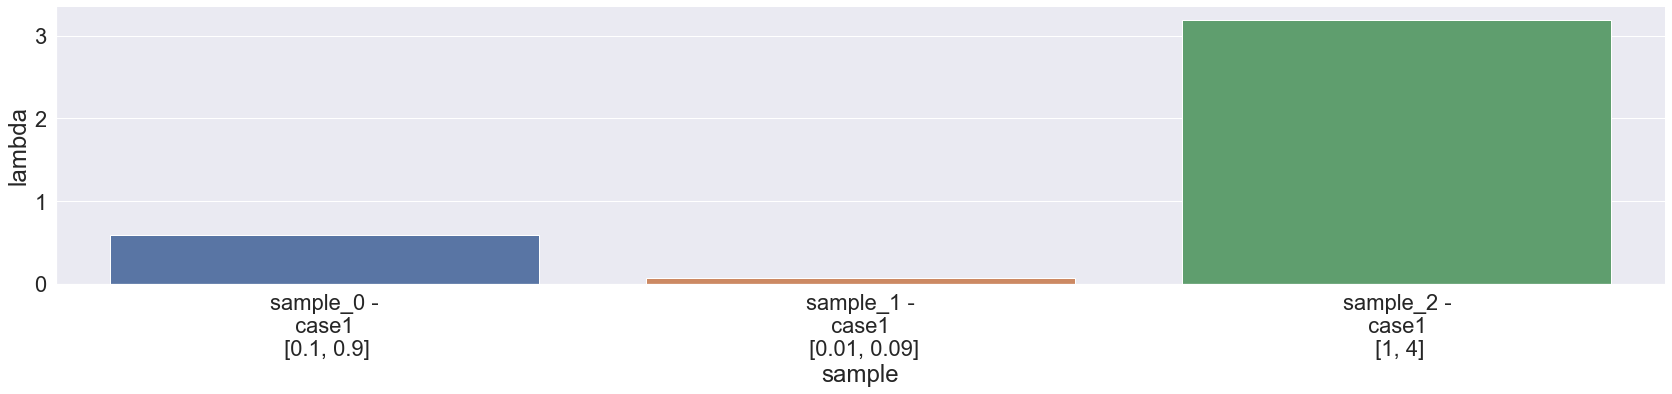

In [146]:
sns.set(font_scale = 2)
sns.catplot(x = 'sample', y = 'lambda', data = plot_df, height=6, aspect=4, kind='bar')